### Jiffy Shirts Data Science Exercise 
#### Abul Hassan Sheikh
#### April 8, 2021

In [1]:
import pandas as pd
import pandasql as pdql
from pandas import read_csv
from matplotlib import pyplot as plt
from datetime import datetime
from datetime import timedelta

In [2]:
# function to run sql query
run_query = lambda q: pdql.sqldf(q, globals())

In [5]:
# Load data sets
line_items = pd.read_csv('line_items.csv',encoding="latin-1")
orders = pd.read_csv('orders.csv',encoding="latin-1")
products = pd.read_csv('products.csv',encoding="latin-1")

data = orders.merge(line_items, how='left', on='order_number')
data = data.merge(products, how='left', on='product_id')

data['date_full']  = pd.to_datetime(data['ordered_at_utc'], format='%Y-%m-%d %H:%M:%S')
data['date'] = data['date_full'].dt.date
data["year"] = data['date_full'].dt.year
data["month"] = data['date_full'].dt.month
data["weekday"] = data['date_full'].dt.weekday
data["hour"] = data['date_full'].dt.hour

### Exercise A ----------

1. How many orders were completed in 2018? (Note: We operate in US/Eastern timezone)

In [4]:
query = '''
        Select 
            count(distinct order_number) as n_order2018
        From 
            orders
        Where 
            strftime('%Y', ordered_at_utc) = "2018"
        '''
run_query(query)

,n_order2018
0,35252


2. How many orders were completed in 2018 containing at least 10 units?

In [30]:
query = '''
        Select 
            distinct(o.order_number)
        From 
            orders as o
        Left Join
            line_items as l
        On
            o.order_number = l.order_number
        Where 
            strftime('%Y', o.ordered_at_utc) = "2018"
        Group by 
            o.order_number
        Having
            sum(l.units_sold) > 9
        '''
run_query(query)

,order_number
0,68096726
1,68124507
2,75900652
3,79924516
4,80958393
...,...
21944,193470312
21945,193474784
21946,193491047
21947,193528604


3. How many customers have ever purchased a medium sized sweater with a discount?

In [6]:
query = '''
        Select 
            count (distinct customer_uuid) as n_msweat_disco
        From 
            orders as o
        Left Join
            line_items as l
        On
            o.order_number = l.order_number
        Left Join
            products as p
        On
            l.product_id = p.product_id
        Where
                p.size = "M"
            And
                p.description like "%Sweater"
            And
                o.discount >0
        '''
run_query(query)

,n_msweat_disco
0,3423


4. How profitable was our most profitable month? (Profit = Revenue - Cost)

In [7]:
query = '''
        Select 
            strftime('%m', o.ordered_at_utc) as month, 
            sum(p.selling_price - p.supplier_cost) as profit
        From 
            orders as o
        Left Join
            line_items as l
        On
            o.order_number = l.order_number
        Left Join
            products as p
        On
            l.product_id = p.product_id
        Group by
            strftime('%m', o.ordered_at_utc)
        Order by
            profit DESC
        Limit 
            1
        '''
run_query(query)

,month,profit
0,10,139087.25


### Exercise B ----------

1. Build a model to forecast daily revenue for the remainder of 2019. You can use any
method you prefer, but please report on your accuracy using a training and test set.

In [8]:
rev_data = data.groupby("date")["selling_price"].agg("sum").reset_index()
rev_data.date = pd.to_datetime(rev_data.date, infer_datetime_format=True)
rev_ts = rev_data.set_index("date")

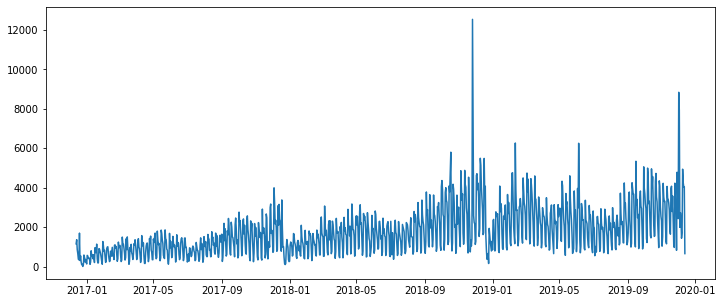

In [9]:
plt.figure(figsize=(12,5))
plt.plot(rev_ts)
# both a weak trend and seasonality can be observed.

In [10]:
# The ts is not stationary and requires transformations 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
adf_pval = adfuller(rev_ts, autolag='AIC')[1]
kpss_pval = kpss(rev_ts, regression='c', nlags="auto")[1]
print("adf_val: ", adf_pval, ", kpss_pval: ", kpss_pval)

adf_val:  0.2525411372734553 , kpss_pval:  0.01


C:\Users\abulh\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


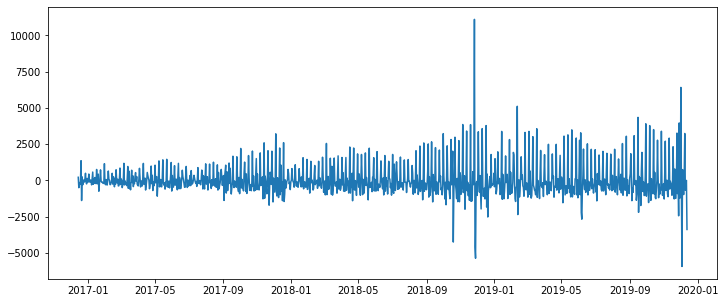

In [11]:
# Take the first difference to determine if it will make the ts stationary
rev_ts_onediff = rev_ts - rev_ts.shift()
rev_ts_onediff.dropna(inplace=True)
plt.figure(figsize=(12,5))
plt.plot(rev_ts_onediff)

In [12]:
# After taking the first diff, 
# the ts is determined to pass both the adfuller & kpss test for stationary

adf_pval = adfuller(rev_ts_onediff, autolag='AIC')[1]
kpss_pval = kpss(rev_ts_onediff, regression='c', nlags="auto")[1]
print("adf_val: ", adf_pval, ", kpss_pval: ", kpss_pval)

adf_val:  4.5285257462400366e-18 , kpss_pval:  0.1


C:\Users\abulh\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [13]:
from pmdarima.arima import auto_arima
arima_model = auto_arima(rev_ts, 
                         start_p=1, max_p=3,
                         start_q=1, max_q=3,
                         m=7,# assuming weekly variation
                         d=1,# Set to one differencing since this will make ts stationary
                         start_P=0, seasonal=True,
                         D=1, trace=True,
                         suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=1.66 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=18049.283, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=17595.873, Time=0.68 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=17241.697, Time=1.08 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=inf, Time=0.30 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=17241.296, Time=1.74 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=17424.215, Time=0.68 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=17233.680, Time=3.75 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=17307.704, Time=1.95 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=inf, Time=6.16 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=2.98 sec
 ARIMA(0,1,0)(2,1,1)[7]             : AIC=17532.322, Time=0.91 sec
 ARIMA(1,1,1)(2,1,1)[7]             : AIC=17148.996, Time=5.46 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=inf, Time=2.39 sec
 ARIMA(1,1,1)(2,1,0)[7]             : AIC=inf, Ti

In [16]:
# Create train/test (80/20)
train = (rev_ts.loc[rev_ts.index[0]:
                            rev_ts.index[0]
                            +timedelta(days=int(len(rev_ts)*.8))])

test = (rev_ts.loc[rev_ts.index[0]
                            +timedelta(days=(int(len(rev_ts)*.8)+1))
                          :rev_ts.index[-1]])

forcast = (pd.DataFrame({"date":pd.date_range(rev_ts.index[-1]+timedelta(days=1)
                                              ,periods=18).tolist(),
                         "selling_price":0}))

forcast = forcast.set_index(forcast["date"])
forcast = forcast.drop("date", axis=1)

test = test.append(forcast, ignore_index=False)

In [18]:
# Train model, generate predictions
arima_model.fit(train)

predict = arima_model.predict(n_periods=len(test))
predict_df = pd.DataFrame({"predict":predict})
predict_df.index = (test.index)

In [19]:
# Evaluate model
results = test.merge(predict_df, how='outer', left_index=True, right_index=True)
performance = test.merge(predict_df, how='outer', left_index=True, right_index=True)

performance['abs_diff'] = abs(performance["selling_price"] - performance["predict"])
performance['abs_diff_norm'] = performance['abs_diff'] /abs(performance["selling_price"])
performance = performance[performance["selling_price"]>0] 

accuracy = sum(performance["selling_price"] - performance["predict"])
mean_accuracy = accuracy/len(performance) 
daily_error = int((abs(mean_accuracy)/(sum(performance["selling_price"])/len(performance)))*100)
mape = int((sum(performance['abs_diff_norm'])/len(performance))*100)

In [20]:
(print('The accuracy between the actual and predicted values is {0}. \nThis translates to an approximate daily error of {1} or {2}%. \nLastly, the mean absolute percent error was found to be {3}% \nwhich suggests that the model performs reasonably well with room for improvement.'.format('${:,.2f}'.format(accuracy),'${:,.2f}'.format(mean_accuracy),daily_error, mape)))

The accuracy between the actual and predicted values is $-81,578.34. 
This translates to an approximate daily error of $-372.50 or 15%. 
Lastly, the mean absolute percent error was found to be 39% 
which suggests that the model performs reasonably well with room for improvement.


2. Plot both the forecasted and actual revenue on a chart.

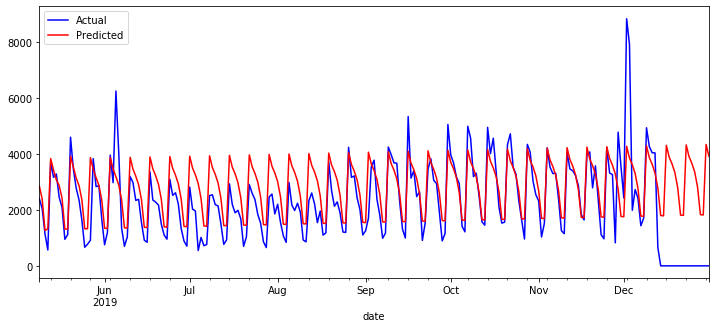

In [21]:
plt.figure(figsize=(12,5))

results.selling_price.plot(color='blue', label='Actual')
results.predict.plot(color='red', label='Predicted')

plt.legend()
plt.show()

In [22]:
results[results["selling_price"]==0][["predict"]]

,predict
date,
2019-12-14,1800.159525
2019-12-15,1789.280559
2019-12-16,4310.368276
2019-12-17,3888.097763
2019-12-18,3649.097799
2019-12-19,3336.189493
2019-12-20,2795.845515
2019-12-21,1816.361944
2019-12-22,1805.482978


### Exercise C ----------

This question is intended to be open-ended. What other trends do you observe in the dataset?
Are there any “nuggets” we could use to enhance our business strategy?

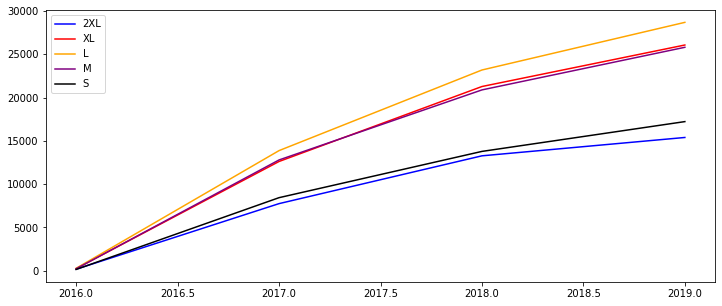

In [23]:
# Understand demographic
size_df = data.groupby(["size", "year"]).agg("count")[["order_number"]].reset_index()
size_df = size_df.set_index(size_df["year"])
size_df = size_df.drop("year", axis=1)

plt.figure(figsize=(12,5))

plt.plot(size_df[size_df["size"]=="2XL"][["order_number"]], color='blue', label='2XL')
plt.plot(size_df[size_df["size"]=="XL"][["order_number"]], color='red', label='XL')
plt.plot(size_df[size_df["size"]=="L"][["order_number"]], color='orange', label='L')
plt.plot(size_df[size_df["size"]=="M"][["order_number"]], color='purple', label='M')
plt.plot(size_df[size_df["size"]=="S"][["order_number"]], color='black', label='S')

plt.legend()
plt.show()


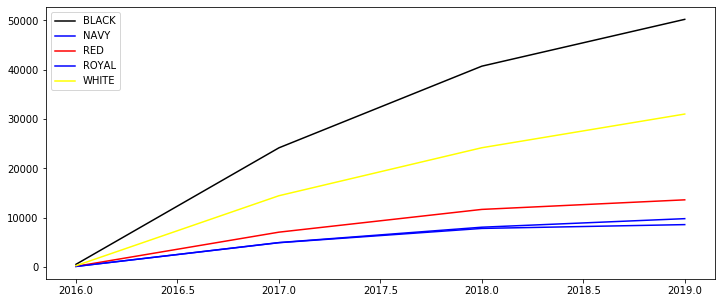

In [24]:
# Understand demographic
group_df = data.groupby(["color", "year"]).agg("count")[["order_number"]].reset_index()
group_df = group_df.set_index(group_df["year"])
group_df = group_df.drop("year", axis=1)
group_df.columns = ["val", "order_number"]

plt.figure(figsize=(12,5))

plt.plot(group_df[group_df["val"]=="BLACK"][["order_number"]], color='black', label='BLACK')
plt.plot(group_df[group_df["val"]=="NAVY"][["order_number"]], color='blue', label='NAVY')
plt.plot(group_df[group_df["val"]=="RED"][["order_number"]], color='red', label='RED')
plt.plot(group_df[group_df["val"]=="ROYAL"][["order_number"]], color='blue', label='ROYAL')
plt.plot(group_df[group_df["val"]=="WHITE"][["order_number"]], color='yellow', label='WHITE')

plt.legend()
plt.show()


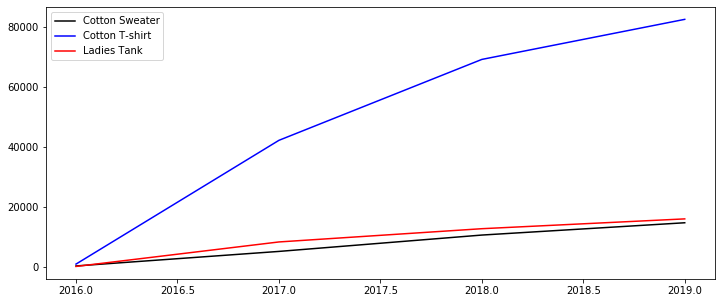

In [25]:
# Understand demographic
group_df = data.groupby(["description", "year"]).agg("count")[["order_number"]].reset_index()
group_df = group_df.set_index(group_df["year"])
group_df = group_df.drop("year", axis=1)
group_df.columns = ["val", "order_number"]

plt.figure(figsize=(12,5))

plt.plot(group_df[group_df["val"]=="Cotton Sweater"][["order_number"]], color='black', label='Cotton Sweater')
plt.plot(group_df[group_df["val"]=="Cotton T-shirt"][["order_number"]], color='blue', label='Cotton T-shirt')
plt.plot(group_df[group_df["val"]=="Ladies Tank"][["order_number"]], color='red', label='Ladies Tank')

plt.legend()
plt.show()


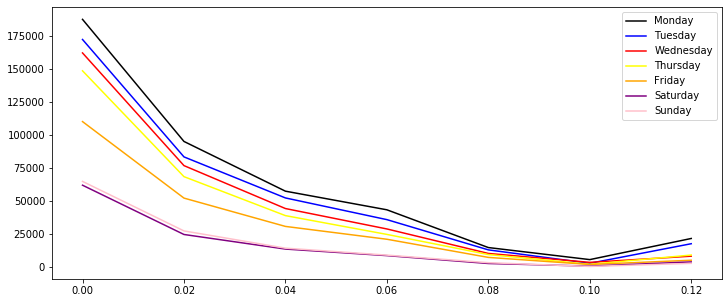

In [26]:
# Identify sales trends
group_df = data.groupby(["weekday", "discount"]).agg("sum")[["selling_price"]].reset_index()
group_df = group_df.set_index(group_df["discount"])
group_df = group_df.drop("discount", axis=1)
group_df.columns = ["val", "order_number"]

plt.figure(figsize=(12,5))

plt.plot(group_df[group_df["val"]==0][["order_number"]], color='black', label='Monday')
plt.plot(group_df[group_df["val"]==1][["order_number"]], color='blue', label='Tuesday')
plt.plot(group_df[group_df["val"]==2][["order_number"]], color='red', label='Wednesday')
plt.plot(group_df[group_df["val"]==3][["order_number"]], color='yellow', label='Thursday')
plt.plot(group_df[group_df["val"]==4][["order_number"]], color='orange', label='Friday')
plt.plot(group_df[group_df["val"]==5][["order_number"]], color='purple', label='Saturday')
plt.plot(group_df[group_df["val"]==6][["order_number"]], color='pink', label='Sunday')

plt.legend()
plt.show()

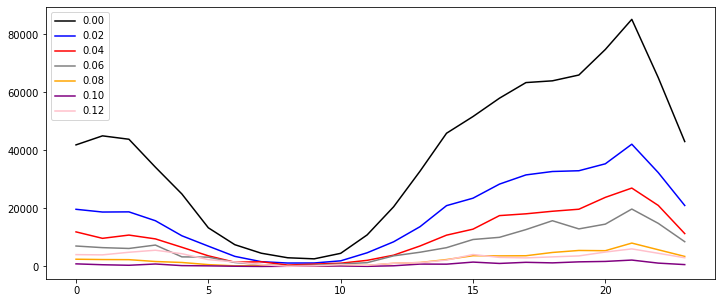

In [27]:
# Identify sales trends
group_df = data.groupby(["hour", "discount"]).agg("sum")[["selling_price"]].reset_index()
group_df = group_df.set_index(group_df["hour"])
group_df = group_df.drop("hour", axis=1)
group_df.columns = ["val", "order_number"]
group_df

plt.figure(figsize=(12,5))

plt.plot(group_df[group_df["val"]==0][["order_number"]], color='black', label='0.00')
plt.plot(group_df[group_df["val"]==0.02][["order_number"]], color='blue', label='0.02')
plt.plot(group_df[group_df["val"]==0.04][["order_number"]], color='red', label='0.04')
plt.plot(group_df[group_df["val"]==0.06][["order_number"]], color='gray', label='0.06')
plt.plot(group_df[group_df["val"]==0.08][["order_number"]], color='orange', label='0.08')
plt.plot(group_df[group_df["val"]==0.10][["order_number"]], color='purple', label='0.10')
plt.plot(group_df[group_df["val"]==0.12][["order_number"]], color='pink', label='0.12')


plt.legend()
plt.show()

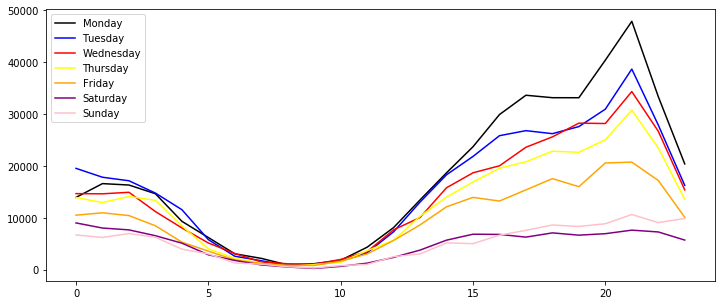

In [28]:
group_df = data.groupby(["hour", "weekday"]).agg("sum")[["selling_price"]].reset_index()
group_df = group_df.set_index(group_df["hour"])
group_df = group_df.drop("hour", axis=1)
group_df.columns = ["val","order_number"]

plt.figure(figsize=(12,5))

plt.plot(group_df[group_df["val"]==0][["order_number"]], color='black', label='Monday')
plt.plot(group_df[group_df["val"]==1][["order_number"]], color='blue', label='Tuesday')
plt.plot(group_df[group_df["val"]==2][["order_number"]], color='red', label='Wednesday')
plt.plot(group_df[group_df["val"]==3][["order_number"]], color='yellow', label='Thursday')
plt.plot(group_df[group_df["val"]==4][["order_number"]], color='orange', label='Friday')
plt.plot(group_df[group_df["val"]==5][["order_number"]], color='purple', label='Saturday')
plt.plot(group_df[group_df["val"]==6][["order_number"]], color='pink', label='Sunday')


plt.legend()
plt.show()

Two sets of trends I observe relate to the consumer demographic and purchasing behavior. 

It can be observed that consumers are increasingly purchasing black t-shirts in the M/L/XL sizes. This suggests that there may be an opportunity available to increase sales by expanding the selection of styles and brands. Also, given the popularity for these t-shirts, the demand curve may be elastic and prices could be increases without impacting demand. 

Purchasing behavior appears to follow the progression of the work week, Monday to Sunday, suggesting that majority of the customer base is associated with business. This would contrast with ecommerce companies who have mostly private individuals as their customer base who would make their purchases heavily on the weekends. 

An observation relates to the impact of various discount rates have on sales. Majority of sales seem to be associated with limited discount rates. This would suggest that most of the prices may be competitive already. That said, there is a potential to increase revenue by limiting the discount range to 2-7%, eg, a discount of 8-12% beings in limits sales. 

Lastly, upon examining the sales distribution for each hour of the weekday, the sales follow the same work week order as mentioned above, eg Monday to Sunday. But the interesting observation is that majority of the sales occur between 12pm-10pm (A) and 12am-5am (B) with a slow down during 5am-12pm. Both the sales volume and discount usage follow this pattern. There is a lot of opportunity available here to improve business, but I believe an impactful strategy would be to target specific website-ads/promotions such that they are inline with the basket composition of window (A) and (B). This has the potential to increasing basket sizes or increase the conversion rate by increasing product visibility dynamically though out the day.
